In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')
ec = pd.read_csv('ec.csv')
votes = pd.read_csv('votes.csv')

## Predicting 2016 U.S. Presidential Election Campaign

The dataset consists of three files:
- data: variables associated with the number of votes associated with each county
- votes: republicans vs democrats vote shares
- ec: electoral vote numbers for each state

The objective of this project is to use 2008 and 2012 vote data to model the outcomes of 2016 results, then comparing to the actual 2016 outcomes so to assess the accuracy of the model. The process begins with data cleaning, followed by EDA, and  lastly model building. According to the U.S. electoral votes, any states with greater than 50% votes of one party automatically wins in that state, therefore a logistic regression is employed assuming that any vote shares great than 50% is a 1 (win) or 0 (lose).

Main packages used in this project includes pandas, statsmodels, and statsmodels. 

## Table of Contents

- [Data Cleaning](#Data-Cleaning)
    - [data.csv](#data.csv)
    - [votes.csv](#votes.csv)
    - [ec.csv](#ec.csv)
- [EDA](#EDA)
- [Visualization](#Visualization)
- [Model Building](#Model-Building)
    - [Results](#Results)
- [Conclusion](#Conclusion)

### Data Cleaning?

Before starting, I will be looking for duplicates and nan values within the data and votes csv, as well as doing sanity checks to get a sense of what the data looks like and how to proceed from here.

#### data.csv

In [3]:
# what does the data look like? How big is it?

print(data.shape)
data.head()

(3141, 54)


,State,ST,Fips,County,Precincts,Votes,Less Than High School Diploma,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,...,Adult.obesity,Diabetes,Sexually.transmitted.infections,HIV.prevalence.rate,Uninsured,Unemployment,Violent.crime,Homicide.rate,Injury.deaths,Infant.mortality
0,Arkansas,AR,5043,"Drew County, Arkansas",17.0,6590.0,19.4,80.6,19.4,5.7,...,0.323,0.126,747.3,79.9,0.197,0.108,449.02,NaN,82.0,NaN
1,Arkansas,AR,5087,"Madison County, Arkansas",20.0,6829.0,24.2,75.8,13.4,4.1,...,0.328,0.135,247.2,131.3,0.239,0.053,245.83,NaN,96.8,NaN
2,Georgia,GA,13159,"Jasper County, Georgia",3.0,6016.0,21.7,78.3,13.3,5.6,...,0.298,0.118,324.1,402.4,0.239,0.096,205.60,NaN,71.6,NaN
3,Colorado,CO,8037,"Eagle County, Colorado",30.0,22611.0,12.8,87.2,45.9,11.7,...,0.132,0.036,190.9,133.7,0.230,0.081,123.88,NaN,42.9,3.5
4,Georgia,GA,13091,"Dodge County, Georgia",16.0,6995.0,23.1,76.9,13.8,4.8,...,0.358,0.153,497.9,315.8,0.208,0.115,477.48,8.11,79.4,NaN


In [4]:
# check for duplicated columns
# race columns are duplicated. For example: 'White (not Latino) Population is the same as the 'White' column
data.T.duplicated()

State                                                         False
ST                                                            False
Fips                                                          False
County                                                        False
Precincts                                                     False
Votes                                                         False
Less Than High School Diploma                                 False
At Least High School Diploma                                  False
At Least Bachelors's Degree                                   False
Graduate Degree                                               False
School Enrollment                                             False
Median Earnings 2010                                          False
White (Not Latino) Population                                 False
African American Population                                   False
Native American Population                      

In [5]:
# drop duplicated columns 

data = data.T.drop_duplicates().T
print(data.shape)
data.head()

(3141, 48)


,State,ST,Fips,County,Precincts,Votes,Less Than High School Diploma,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,...,Adult.obesity,Diabetes,Sexually.transmitted.infections,HIV.prevalence.rate,Uninsured,Unemployment,Violent.crime,Homicide.rate,Injury.deaths,Infant.mortality
0,Arkansas,AR,5043,"Drew County, Arkansas",17,6590,19.4,80.6,19.4,5.7,...,0.323,0.126,747.3,79.9,0.197,0.108,449.02,NaN,82,NaN
1,Arkansas,AR,5087,"Madison County, Arkansas",20,6829,24.2,75.8,13.4,4.1,...,0.328,0.135,247.2,131.3,0.239,0.053,245.83,NaN,96.8,NaN
2,Georgia,GA,13159,"Jasper County, Georgia",3,6016,21.7,78.3,13.3,5.6,...,0.298,0.118,324.1,402.4,0.239,0.096,205.6,NaN,71.6,NaN
3,Colorado,CO,8037,"Eagle County, Colorado",30,22611,12.8,87.2,45.9,11.7,...,0.132,0.036,190.9,133.7,0.23,0.081,123.88,NaN,42.9,3.5
4,Georgia,GA,13091,"Dodge County, Georgia",16,6995,23.1,76.9,13.8,4.8,...,0.358,0.153,497.9,315.8,0.208,0.115,477.48,8.11,79.4,NaN


In [6]:
# checking for nan values

data.isna().sum()

State                                                            0
ST                                                               1
Fips                                                             0
County                                                           0
Precincts                                                       32
Votes                                                           32
Less Than High School Diploma                                    0
At Least High School Diploma                                     0
At Least Bachelors's Degree                                      0
Graduate Degree                                                  0
School Enrollment                                                0
Median Earnings 2010                                             0
White (Not Latino) Population                                    0
African American Population                                      0
Native American Population                                    

In [7]:
#Columns with high nan values such as homicide rate accounts for more than half of the dataset. To preserve most of 
#the data points to work with, I chose to drop columsn with more than 100 (out of 3000) nans in one column. 

NAN = []

for index,col in enumerate(data.isna().sum()):
    if col > 32:
        NAN.append(data.isna().sum().index[index])
        
data.drop(columns=NAN, inplace=True)
print(data.shape)
data.head()

(3141, 39)


,State,ST,Fips,County,Precincts,Votes,Less Than High School Diploma,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,...,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,White_Asian,SIRE_homogeneity,median_age,Children.in.single.parent.households,Adult.obesity,Diabetes,Uninsured,Unemployment
0,Arkansas,AR,5043,"Drew County, Arkansas",17,6590,19.4,80.6,19.4,5.7,...,9.4,20.2,68.45,0.539968,36.8,0.429,0.323,0.126,0.197,0.108
1,Arkansas,AR,5087,"Madison County, Arkansas",20,6829,24.2,75.8,13.4,4.1,...,16.2,19.4,92.3,0.849006,38.5,0.179,0.328,0.135,0.239,0.053
2,Georgia,GA,13159,"Jasper County, Georgia",3,6016,21.7,78.3,13.3,5.6,...,15.1,19.25,72.8,0.579201,38.1,0.381,0.298,0.118,0.239,0.096
3,Colorado,CO,8037,"Eagle County, Colorado",30,22611,12.8,87.2,45.9,11.7,...,15.5,6.3,69.55,0.551646,33.4,0.204,0.132,0.036,0.23,0.081
4,Georgia,GA,13091,"Dodge County, Georgia",16,6995,23.1,76.9,13.8,4.8,...,11.35,18.85,66.6,0.527235,37.7,0.453,0.358,0.153,0.208,0.115


In [8]:
#Dropping the remaining rows of nan values (since there are only 32 of them). Also dropping the column 'White Asian', 
# it is just a sum column of 'White' and 'Asian'

data.dropna(inplace=True)
data.drop(columns='White_Asian',inplace=True)
print(data.shape)
data.head()

(3102, 38)


,State,ST,Fips,County,Precincts,Votes,Less Than High School Diploma,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,...,Farming.fishing.and.forestry.occupations,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,SIRE_homogeneity,median_age,Children.in.single.parent.households,Adult.obesity,Diabetes,Uninsured,Unemployment
0,Arkansas,AR,5043,"Drew County, Arkansas",17,6590,19.4,80.6,19.4,5.7,...,3.6,9.4,20.2,0.539968,36.8,0.429,0.323,0.126,0.197,0.108
1,Arkansas,AR,5087,"Madison County, Arkansas",20,6829,24.2,75.8,13.4,4.1,...,2.9,16.2,19.4,0.849006,38.5,0.179,0.328,0.135,0.239,0.053
2,Georgia,GA,13159,"Jasper County, Georgia",3,6016,21.7,78.3,13.3,5.6,...,4.35,15.1,19.25,0.579201,38.1,0.381,0.298,0.118,0.239,0.096
3,Colorado,CO,8037,"Eagle County, Colorado",30,22611,12.8,87.2,45.9,11.7,...,0.45,15.5,6.3,0.551646,33.4,0.204,0.132,0.036,0.23,0.081
4,Georgia,GA,13091,"Dodge County, Georgia",16,6995,23.1,76.9,13.8,4.8,...,1.6,11.35,18.85,0.527235,37.7,0.453,0.358,0.153,0.208,0.115


#### votes.csv

In [9]:
# What does the data look like?

votes_og = votes.copy
print(votes.shape)
votes.head()

(3141, 7)


,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),votes16_trumpd,votes16_clintonh,Fips
0,2598.0,2630.0,3860.0,3887.0,3967.0,2364.0,5043
1,2144.0,2099.0,3972.0,4263.0,4917.0,1587.0,5087
2,1935.0,1845.0,3916.0,4136.0,4353.0,1544.0,13159
3,13191.0,12792.0,8181.0,9411.0,8153.0,12652.0,8037
4,2595.0,2442.0,5543.0,5214.0,5021.0,1836.0,13091


In [10]:
# checking for nans

votes.isna().sum()

Democrats 08 (Votes)      31
Democrats 12 (Votes)      31
Republicans 08 (Votes)    31
Republicans 12 (Votes)    31
votes16_trumpd            32
votes16_clintonh          32
Fips                       0
dtype: int64

In [11]:
# dropping the 32 rows, shouldn't make a big difference in the entire dataset overall

votes.dropna(inplace=True)
print(votes.shape)
votes.head()

(3109, 7)


,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),votes16_trumpd,votes16_clintonh,Fips
0,2598.0,2630.0,3860.0,3887.0,3967.0,2364.0,5043
1,2144.0,2099.0,3972.0,4263.0,4917.0,1587.0,5087
2,1935.0,1845.0,3916.0,4136.0,4353.0,1544.0,13159
3,13191.0,12792.0,8181.0,9411.0,8153.0,12652.0,8037
4,2595.0,2442.0,5543.0,5214.0,5021.0,1836.0,13091


In [12]:
# renaming and ordering the column headers

votes.rename(columns={
    'Democrats 08 (Votes)': 'D_08',
    'Republicans 08 (Votes)': 'R_08',
    'Democrats 12 (Votes)': 'D_12',
    'Republicans 12 (Votes)': 'R_12',
    'votes16_trumpd': 'R_16',
    'votes16_clintonh': 'D_16',
}, inplace = True)

votes=votes[['Fips','D_08', 'R_08', 'D_12', 'R_12', 'D_16', 'R_16']]
votes.head()

,Fips,D_08,R_08,D_12,R_12,D_16,R_16
0,5043,2598.0,3860.0,2630.0,3887.0,2364.0,3967.0
1,5087,2144.0,3972.0,2099.0,4263.0,1587.0,4917.0
2,13159,1935.0,3916.0,1845.0,4136.0,1544.0,4353.0
3,8037,13191.0,8181.0,12792.0,9411.0,12652.0,8153.0
4,13091,2595.0,5543.0,2442.0,5214.0,1836.0,5021.0


#### ec.csv

In [13]:
# What does the data look like?

ec

,State,EC_votes
0,Alabama,9
1,Alaska,3
2,Arizona,11
3,Arkansas,6
4,California,55
5,Colorado,9
6,Connecticut,7
7,Delaware,3
8,District of Columbia,3
9,Florida,29


### EDA

From here onwards, I will be working with the relative vote shares counts of the republicans and democrats in percentages. In addition, I will be specifically looking at the republicans party going forward. This section will include exploring the correlation of vote shares with the features provided in the data.csv

In [14]:
# creating a dataframe with percentages of vote shares for both parties, for each of the three election years

year_D = ['D_08','D_12','D_16']
year_R = ['R_08','R_12','R_16']

def compute_percentage(vote,year):
    pct = (vote/(vote+year) * 100)
    return round(pct, 2)

for i, col in enumerate(year_D):
    votes[col] = compute_percentage(votes[year_D[i]], votes[year_R[i]])

for index, col_r in enumerate(year_R):
    votes[col_r] = 100-votes[year_D[index]]
    
votes.head()

,Fips,D_08,R_08,D_12,R_12,D_16,R_16
0,5043,40.23,59.77,40.36,59.64,37.34,62.66
1,5087,35.06,64.94,32.99,67.01,24.40,75.60
2,13159,33.07,66.93,30.85,69.15,26.18,73.82
3,8037,61.72,38.28,57.61,42.39,60.81,39.19
4,13091,31.89,68.11,31.90,68.10,26.78,73.22


In [15]:
# what columns are correlated with the republican votes? Only looking at republicans because the democrats correlation would
# be the same value but of the opposite sign

rep = votes[['Fips', 'R_08', 'R_12', 'R_16']]
dem = votes[['Fips', 'D_08', 'D_12', 'D_16']]

for col in data:
    data[col]=pd.to_numeric(data[col], errors='coerce')

republicans = rep.merge(data, how='inner', on='Fips')
democrats = dem.merge(data, how='inner', on='Fips')

republicans.dropna(axis=1, inplace=True)
democrats.dropna(axis=1, inplace=True)

corr_r=republicans.corr()
corr_d=democrats.corr()

corr_r=corr_r.iloc[6:,1:4]
corr_r

,R_08,R_12,R_16
Less Than High School Diploma,0.091093,0.052906,0.062342
At Least High School Diploma,-0.082700,-0.044877,-0.053559
At Least Bachelors's Degree,-0.307016,-0.305642,-0.467061
Graduate Degree,-0.369002,-0.371141,-0.518709
School Enrollment,-0.145177,-0.141624,-0.175679
Median Earnings 2010,-0.115546,-0.123698,-0.199772
White (Not Latino) Population,0.356515,0.445607,0.568203
African American Population,-0.312629,-0.394210,-0.461517
Native American Population,-0.113922,-0.113958,-0.089128
Asian American Population,-0.320296,-0.335262,-0.433936


In [16]:
# isolating several features with correlation greater than .30 or less than -.30, aka more highly correlated with the 
# republican vote shares; the same features seem to appear in every year pretty consistently. 

for col in corr_r:
    print(corr_r[(corr_r[col]<-0.30) | (corr_r[col]>0.30)][col])

At Least Bachelors's Degree                                  -0.307016
Graduate Degree                                              -0.369002
White (Not Latino) Population                                 0.356515
African American Population                                  -0.312629
Asian American Population                                    -0.320296
Construction.extraction.maintenance.and.repair.occupations    0.348316
Children.in.single.parent.households                         -0.365433
Uninsured                                                     0.305177
Unemployment                                                 -0.309152
Name: R_08, dtype: float64
At Least Bachelors's Degree                                  -0.305642
Graduate Degree                                              -0.371141
White (Not Latino) Population                                 0.445607
African American Population                                  -0.394210
Asian American Population                         

Would be interesting to look at the correlation between races and votes shares, on a county and state level (drastic different population may skew results).

In [17]:
# so far we have been looking at correlation with republican shares at a county level, however state population is a 
# confounding variable which will affect out results. Hence to account for this effect, I will use the weighted avg of 
# each state and look at the correlation at a state level and see if the same result still holds

data_state = pd.read_csv('data.csv')
states=data_state.iloc[:,[0,2,20]]
states.rename(columns={'Total Population':'County Population'},inplace=True)

state_pop = states.iloc[:,[0,2]].groupby(states['State']).sum()
state_pop.rename(columns={'County Population':'State Population'},inplace=True)
states = states.merge(state_pop, how='left', on='State')
states['Weighted Avg']=states['County Population']/states['State Population']
weighted_avg=states.iloc[:,[1,-1]]

republicans = republicans.merge(weighted_avg, how='left', on='Fips')
republicans['R_08_WA'] = republicans['R_08']*republicans['Weighted Avg']
republicans['R_12_WA'] = republicans['R_12']*republicans['Weighted Avg']
republicans['R_16_WA'] = republicans['R_16']*republicans['Weighted Avg']

In [18]:
corr_r.T.iloc[:,6:12]

,White (Not Latino) Population,African American Population,Native American Population,Asian American Population,Other Race or Races,Latino Population
R_08,0.356515,-0.312629,-0.113922,-0.320296,-0.106967,-0.060305
R_12,0.445607,-0.394210,-0.113958,-0.335262,-0.122410,-0.097538
R_16,0.568203,-0.461517,-0.089128,-0.433936,-0.146314,-0.196740


In [19]:
republicans.iloc[:,[-2,-3,-4,12,13,14,15,16,17]].corr().iloc[:3,3:]

,White (Not Latino) Population,African American Population,Native American Population,Asian American Population,Other Race or Races,Latino Population
R_12_WA,-0.078889,-0.002447,-0.019819,0.327978,0.201303,0.049459
R_08_WA,-0.088880,0.005772,-0.020181,0.336104,0.203066,0.053726
Weighted Avg,-0.141029,0.054213,-0.018688,0.390942,0.228972,0.064097


In [20]:
corr_r_state=republicans.iloc[:,[-2,-3,-4,12,13,14,15,16,17]].corr()
corr_r_state=corr_r_state.iloc[:3,3:]
corr_r_state.iloc[::-1]

,White (Not Latino) Population,African American Population,Native American Population,Asian American Population,Other Race or Races,Latino Population
Weighted Avg,-0.141029,0.054213,-0.018688,0.390942,0.228972,0.064097
R_08_WA,-0.088880,0.005772,-0.020181,0.336104,0.203066,0.053726
R_12_WA,-0.078889,-0.002447,-0.019819,0.327978,0.201303,0.049459


In [21]:
state_fips=data_state.iloc[:,[0,2]]
republicans = republicans.merge(state_fips, how='inner', on='Fips')
republicans.iloc[:,[-1,-2,-3,-4,12,13,14,15,16,17]].groupby(republicans['State']).sum()

,R_16_WA,R_12_WA,R_08_WA,White (Not Latino) Population,African American Population,Native American Population,Asian American Population,Other Race or Races,Latino Population
State,,,,,,,,,
Alabama,64.405013,61.715840,61.516738,4465.70,1891.45,41.20,36.55,79.45,185.30
Arizona,52.050548,54.650360,54.437223,798.30,24.40,197.25,16.60,26.25,437.50
Arkansas,63.637524,61.983081,60.153907,5644.95,1141.20,44.30,41.70,105.40,323.00
California,34.964059,38.437157,38.232399,3377.15,181.65,98.80,370.00,179.05,1593.35
Colorado,47.761425,47.394984,45.587166,4815.25,84.35,58.05,64.70,99.55,1178.10
Connecticut,42.918282,41.149759,38.641701,637.20,48.95,1.65,23.35,15.65,73.15
Delaware,43.507122,40.517336,37.618293,206.90,57.75,1.15,7.00,6.40,20.75
District of Columbia,4.250000,7.410000,6.600000,33.35,52.30,0.20,3.20,2.10,8.80
Florida,49.692475,48.774254,47.990766,4745.30,923.95,29.95,94.25,109.65,797.10


The strong correlation we saw at the county level has significantly dampered down for White, African American, and Native American populations. In addition, the signs have reversed as well. This is probably due to the fact that the races in a few of the larger states voted against republicans whilst many smaller states voted for, hence when we accounted for the population size the result has changed. Same logic applies to Asian, Latino and other races.

### Visualization

In [22]:
democrats = democrats.merge(weighted_avg, how='left', on='Fips')
democrats = democrats.merge(state_fips, how='inner', on='Fips')

democrats['D_08_WA'] = democrats['D_08']*democrats['Weighted Avg']
democrats['D_12_WA'] = democrats['D_12']*democrats['Weighted Avg']
democrats['D_16_WA'] = democrats['D_16']*democrats['Weighted Avg']

democrats.groupby(democrats['State']).sum().iloc[:,[-3,-2,-1]]

,D_08_WA,D_12_WA,D_16_WA
State,,,
Alabama,38.483262,38.284160,35.594987
Arizona,45.562777,45.349640,47.949452
Arkansas,39.846093,38.016919,36.362476
California,61.767601,61.562843,65.035941
Colorado,54.394723,52.586904,52.220464
Connecticut,61.358299,58.850241,57.081718
Delaware,62.381707,59.482664,56.492878
District of Columbia,93.400000,92.590000,95.750000
Florida,52.009234,51.225746,50.307525


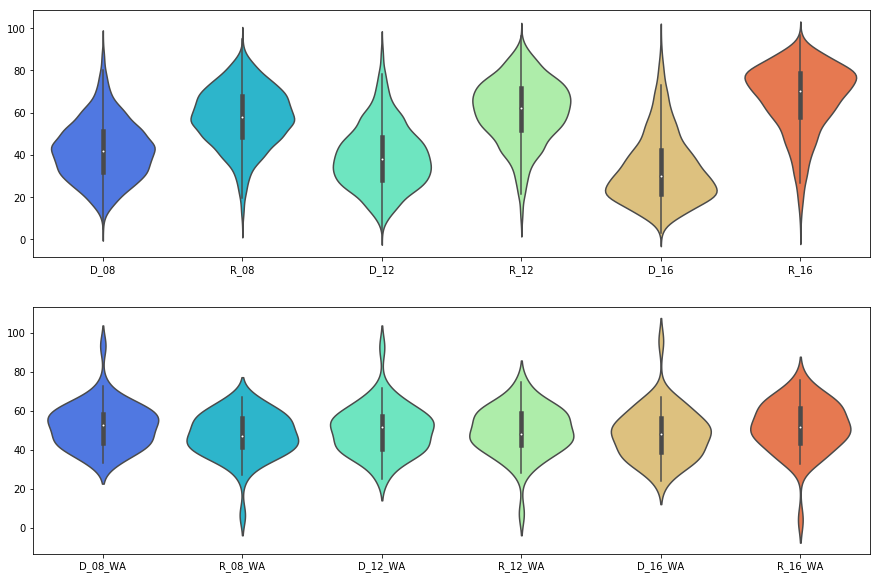

In [23]:
dist_plot_r=republicans.groupby(republicans['State']).sum().iloc[:,[-3,-2,-1]]
dist_plot_d=democrats.groupby(democrats['State']).sum().iloc[:,[-3,-2,-1]]

dist_plot=pd.concat([dist_plot_d,dist_plot_r], axis=1, sort=False)

dist_plot = dist_plot[['D_08_WA','R_08_WA','D_12_WA','R_12_WA', 'D_16_WA','R_16_WA']]

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
sns.violinplot(data=votes.iloc[:,1:], palette='rainbow')
plt.subplot(2,1,2)
sns.violinplot(data=dist_plot, palette='rainbow')

Putting the above distribution plots side by side, we can see that after weighing each state's vote share by its population size, the distribution is much more smooth with the mode at approximately 50%.

- I used an one-way ANOVA test to compare the means of one or more samples, which is a way to test for similarity; however, using an ANOVA test breaks the conditions that we are assuming the poulation variances are equal and the response variable residuals are normally distributed
    - On a county level, p-value is 1.57e-120, indicating we can reject the null hypothesis, that samples in all groups are not drawn from populations with the same mean values. 
    - However the p-value on a state level is 0.20763971, which is not small enough to reject the null hypothesis, hence the samples from all three election years are not significantly different

In [24]:
r_08=votes['R_08'].values
r_12=votes['R_12'].values
r_16=votes['R_16'].values

d_08=votes['D_08'].values
d_12=votes['D_12'].values
d_16=votes['D_16'].values

r_08_state=dist_plot_r['R_08_WA'].values
r_12_state=dist_plot_r['R_12_WA'].values
r_16_state=dist_plot_r['R_16_WA'].values

d_08_state=dist_plot_d['D_08_WA'].values
d_12_state=dist_plot_d['D_12_WA'].values
d_16_state=dist_plot_d['D_16_WA'].values

print(f'Republicans at County Level: {stats.f_oneway(r_08, r_12, r_16)}')
print(f'Democrats at County Level: {stats.f_oneway(d_08, d_12, d_16)}')

print(f'Republicans at State Level: {stats.f_oneway(r_08_state, r_12_state, r_16_state)}')
print(f'Democrats at State Level: {stats.f_oneway(d_08_state, d_12_state, d_16_state)}')


Republicans at County Level: F_onewayResult(statistic=284.1856470016214, pvalue=1.5676682398916176e-120)
Democrats at County Level: F_onewayResult(statistic=284.1856470016214, pvalue=1.5676682398916176e-120)
Republicans at State Level: F_onewayResult(statistic=1.5906000275888674, pvalue=0.20729063636703327)
Democrats at State Level: F_onewayResult(statistic=1.5822385688209357, pvalue=0.20899423075687518)


### Model Building

Since there are 34 features to work with, I assume some of these feature are correlated with each other. To account for this, I choose to eliminate one of the columns with a correlation greater than .80 with another column, this way we can control the colinearity in the feature variables to some extent. 

In [25]:
republicans_model=republicans

R_08_model=republicans_model.drop(columns=['Fips', 'R_12', 'R_16', 'Precincts', 'Votes','R_12_WA', 'R_08_WA', 'R_16_WA', 'State'])
R_08_model.rename(columns={'R_08':'votes'},inplace=True)


R_12_model=republicans_model.drop(columns=['Fips', 'R_08', 'R_16', 'Precincts', 'Votes','R_12_WA', 'R_08_WA', 'R_16_WA', 'State'])
R_12_model.rename(columns={'R_12':'votes'},inplace=True)

R_16_model=republicans_model.drop(columns=['Fips', 'R_08', 'R_12', 'Precincts', 'Votes','R_12_WA', 'R_08_WA', 'R_16_WA', 'State'])
R_16_model.rename(columns={'R_16':'votes'},inplace=True)

r_vote_share=pd.concat([R_08_model,R_12_model], axis=0, sort=False)
r_vote_share.shape

(6204, 34)

In [26]:
import itertools

colinear_col = []
for col_1, col_2 in itertools.combinations(republicans.iloc[:,6:-5].corr().columns, 2):
    coefficient, pvalue = stats.pearsonr(republicans.iloc[:,6:-5].corr()[col_1], republicans.iloc[:,6:-5].corr()[col_2])
    if abs(coefficient) >= .8:
        print(f'Pearson r = {coefficient:.2f} for {col_1} & {col_2}')
        colinear_col.append(col_2)
colinear_col = set(colinear_col)
# print(colinear_col)
# print(len(colinear_col))

Pearson r = -1.00 for Less Than High School Diploma & At Least High School Diploma
Pearson r = -0.86 for Less Than High School Diploma & At Least Bachelors's Degree
Pearson r = -0.82 for Less Than High School Diploma & School Enrollment
Pearson r = -0.85 for Less Than High School Diploma & Median Earnings 2010
Pearson r = 0.93 for Less Than High School Diploma & Children Under 6 Living in Poverty
Pearson r = 0.96 for Less Than High School Diploma & Adults 65 and Older Living in Poverty
Pearson r = 0.94 for Less Than High School Diploma & Poverty.Rate.below.federal.poverty.threshold
Pearson r = 0.95 for Less Than High School Diploma & Child.Poverty.living.in.families.below.the.poverty.line
Pearson r = -0.88 for Less Than High School Diploma & Management.professional.and.related.occupations
Pearson r = 0.83 for Less Than High School Diploma & Children.in.single.parent.households
Pearson r = 0.83 for Less Than High School Diploma & Adult.obesity
Pearson r = 0.88 for Less Than High School 

In [27]:
r_vote_share.drop(columns=colinear_col, inplace=True)
r_vote_share.head()

,votes,Less Than High School Diploma,White (Not Latino) Population,Native American Population,Other Race or Races,Latino Population,Preschool.Enrollment.Ratio.enrolled.ages.3.and.4,Service.occupations,Sales.and.office.occupations,Farming.fishing.and.forestry.occupations,Construction.extraction.maintenance.and.repair.occupations,median_age,Weighted Avg
0,59.77,19.4,67.90,0.15,0.85,2.65,73.5,18.25,20.15,3.60,9.40,36.8,0.006638
1,64.94,24.2,92.00,1.25,1.50,4.70,43.8,16.85,19.55,2.90,16.20,38.5,0.005565
2,66.93,21.7,72.70,0.40,1.05,3.55,36.5,17.15,22.60,4.35,15.10,38.1,0.001433
3,38.28,12.8,68.40,0.25,1.10,28.90,50.7,24.80,20.05,0.45,15.50,33.4,0.010414
4,68.11,23.1,66.15,0.15,0.65,2.80,41.5,20.05,22.00,1.60,11.35,37.7,0.002163


Converting the probability of vote shares into numbers with inverse_logit function to plug into linear regression, cannot use a logistic function here since its outputs are between 0 and 1. Subsquently, subsituting the numbers into a logistic function to get a predicted probabilities. Here I assigned counties with greater than 50% vote as 1 (since they have won in that area), and 0 for less than 50%.

The dilemma here is to play around with the value of colinearity amongst the features. With a higher colinearity threshold (>0.80), we keep more features to plug into our model, we get a higher R-squared but the value of multicolinearity remains high. On the contrary, with a lower colinearity threshold, we are able to rid most of the features and account for the multicolinearity problem, but our R-squared drops to approximately 0.20. Therefore, it would be helpful to somehow optimize for the colinearity threshold to set so to balance out the multicolinearity effect and the R-squared value. 

Using the 2008 and 2012 data, the accuracy from the model was around 90%, compared to a baseline accuracy of 67%. 

In [28]:
X=sm.add_constant(r_vote_share.iloc[:,1:-1])
y=r_vote_share['votes']

print(X.shape)
print(y.shape)

(6204, 12)
(6204,)


In [29]:
def inverse_logit(y):
    return -np.log((1/y)-1)

def logit(prediction_2016):
    return 1/(1+ np.exp(-prediction_2016))

#### Results

In [30]:
# unweighted avg and .8 corrleation

election_model = sm.OLS(inverse_logit(y/100),X).fit()
display(election_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     390.0
Date:                Wed, 02 Jan 2019   Prob (F-statistic):               0.00
Time:                        13:45:48   Log-Likelihood:                -4646.9
No. Observations:                6204   AIC:                             9318.
Df Residuals:                    6192   BIC:                             9399.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -1.2191      0.116    -10.508      0.000      -1.447      -0.992
Less Than High School Diploma                                  0.0146      0.001     12.623      0.000       0.012       0.017
White (Not Latino) Population                                  0.0186      0.001     33.516      0.000       0.017       0.020
Native American Population                                     0.0021      0.001      1.775      0.076      -0.000       0.004
Other Race or Races                                            0.0120      0.005      2.557      0.011       0.003       0.021
Latino Population                                              0.0058      0.001      8.390      0.000       0.004       0.007
Preschool.Enrollment.Ratio.enrolled.ages.3.and.4              -0.0035      0.000     -7.196      0.000      -0.004      -0.003
Service.occupations                                           -0.0289      0.002    -14.131      0.000      -0.033      -0.025
Sales.and.office.occupations                                   0.0079      0.002      3.355      0.001       0.003       0.012
Farming.fishing.and.forestry.occupations                       0.0704      0.003     22.093      0.000       0.064       0.077
Construction.extraction.maintenance.and.repair.occupations     0.0535      0.002     24.495      0.000       0.049       0.058
median_age                                                    -0.0112      0.002     -6.965      0.000      -0.014      -0.008
==============================================================================
Omnibus:                       21.790   Durbin-Watson:                   1.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.678
Skew:                           0.044   Prob(JB):                     9.77e-07
Kurtosis:                       3.315   Cond. No.                     1.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
prediction_2016 = election_model.predict()

In [32]:
copy_16=R_16_model
R_16_model=pd.concat([R_16_model,copy_16],axis=0)

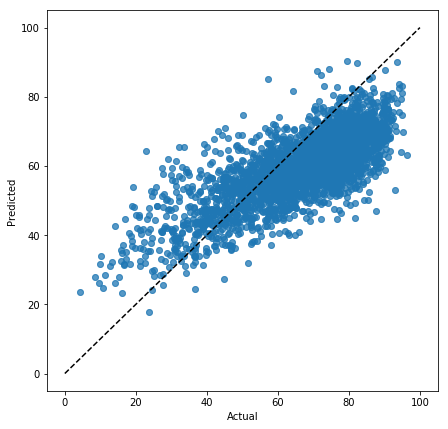

Accuracy 0.8961960025789814
Baseline accuracy 66.69116698903933


In [33]:
plt.figure(figsize=(7, 7))
plt.plot(R_16_model['votes'], (logit(prediction_2016))*100, 'o', alpha=0.5)
plt.plot([0, 100], [0, 100], linestyle='--', color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

print('Accuracy', accuracy_score((R_16_model['votes']/100).round(), logit(prediction_2016).round()))
print('Baseline accuracy', (R_16_model['votes']).round().mean())

Using the EC votes data table to compute how many electoral votes the republican party has received after accounting for each state's population size.

In [34]:
predicted = pd.DataFrame(logit(prediction_2016)*100,
                    columns=['predicted'])
predicted=predicted.iloc[:3102,:]
ec_weights=republicans_model.iloc[:, [-1, -5]]
ec_weights=pd.concat([ec_weights,predicted], axis=1)
ec_weights['weighted_predicted']=(ec_weights['Weighted Avg']*ec_weights['predicted'])

ec_weights=ec_weights.groupby(ec_weights['State']).sum()[['weighted_predicted']].round()

In [35]:
ec_votes = ec.merge(ec_weights, how='inner', on='State')
ec_votes['win']=np.where(ec_votes['weighted_predicted']>50,1,0)

ec_votes['rep_ec_votes'] = ec_votes['win']*ec_votes['EC_votes']
ec_votes['rep_ec_votes'].sum()

241

### Conclusion

Accounting for the electoral votes given our prediction above for 2016, the total votes republicans party received was 241, compared to the actual total of 304. The model incorrectly predicted the outcome even though it scored an accruacy of 90%, indicating that the correlation of vote shares and available features are not enough to predict election results. Furthermore, there are a multitude of factors which can also contribute to presidential campaigns which are not listed in our dataset. It would be interesting to see whether randomly train test splited the data for all three election years aggregated would show that the model is actually overfitting and hence doing poorly on the actual predictions in this case.  